In [5]:
!pip install opencv-python

In [6]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [7]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

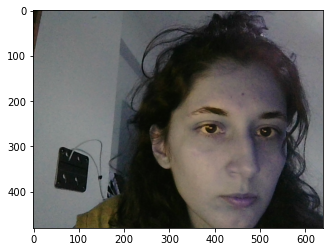

In [14]:
plt.imshow(frame)

In [15]:
img = frame.copy()

In [16]:
np.expand_dims(img,axis=0)

array([[[[ 47,  16,  15],
         [ 43,  14,  12],
         [ 40,  16,  13],
         ...,
         [159, 159, 165],
         [158, 159, 165],
         [157, 160, 165]],

        [[ 47,  18,  17],
         [ 45,  19,  16],
         [ 42,  21,  17],
         ...,
         [158, 158, 164],
         [157, 158, 164],
         [156, 157, 163]],

        [[ 41,  17,  15],
         [ 39,  17,  14],
         [ 35,  19,  14],
         ...,
         [158, 158, 164],
         [156, 156, 162],
         [156, 156, 162]],

        ...,

        [[115, 121, 127],
         [113, 120, 125],
         [113, 120, 125],
         ...,
         [ 20,  20,  20],
         [ 20,  20,  20],
         [ 21,  21,  21]],

        [[116, 122, 128],
         [115, 122, 128],
         [115, 122, 127],
         ...,
         [ 21,  21,  21],
         [ 20,  20,  20],
         [ 22,  22,  22]],

        [[110, 116, 123],
         [112, 119, 125],
         [115, 122, 128],
         ...,
         [ 20,  20,  20],
        

In [17]:
img.shape

(480, 640, 3)

In [18]:
np.expand_dims(img,axis=0).shape

(1, 480, 640, 3)

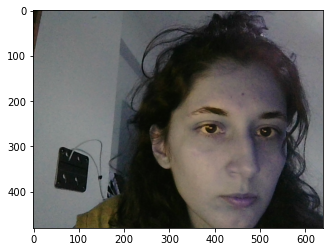

In [21]:
plt.imshow(tf.cast(np.squeeze(img), dtype=tf.int32))

In [22]:
interpreter.get_input_details()

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 192, 192,   3]),
  'shape_signature': array([  1, 192, 192,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [23]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 312,
  'shape': array([ 1,  1, 17,  3]),
  'shape_signature': array([ 1,  1, 17,  3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [37]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #reshape the image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img,axis=0),192,192)
    input_image = tf.cast(img,dtype=tf.float32)

#setting input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

#make predictions
    interpreter.set_tensor(input_details[0]['index'],np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    print(keypoints_with_scores)
    
#Rendering
    draw_connections(frame,keypoints_with_scores,EDGES,0.4)
    draw_keypoints(frame,keypoints_with_scores,0.4)

    cv2.imshow("Movenet Lightning",frame)

    if cv2.waitKey(10) & 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[[[[6.3188958e-01 5.7454097e-01 7.2574854e-01]
   [5.4809618e-01 6.5093321e-01 6.8798864e-01]
   [5.3547829e-01 4.8234510e-01 7.9912841e-01]
   [6.2301600e-01 7.0153248e-01 6.4939445e-01]
   [6.1755544e-01 3.7412494e-01 6.6997814e-01]
   [8.6475813e-01 8.4940785e-01 5.0909603e-01]
   [8.8470626e-01 2.1897477e-01 6.4803612e-01]
   [9.6963519e-01 9.5786685e-01 5.2595437e-02]
   [9.7142684e-01 6.9323540e-02 4.4017572e-02]
   [9.9268878e-01 9.8894638e-01 4.4076253e-02]
   [9.8992437e-01 3.3277142e-01 8.0379238e-03]
   [2.8591359e-01 6.0367620e-01 5.6246899e-02]
   [4.4779801e-01 3.2550985e-01 2.6741436e-02]
   [8.2212973e-01 8.9480484e-01 3.2453991e-02]
   [8.7941778e-01 2.0991698e-01 1.5118661e-02]
   [6.0186595e-01 7.9466879e-01 2.6950160e-02]
   [8.2918406e-01 1.7426885e-04 1.1578014e-02]]]]
[[[[0.6293944  0.573323   0.62854964]
   [0.5482125  0.6500763  0.74805343]
   [0.53414166 0.4809441  0.7845608 ]
   [0.62273216 0.7031827  0.47361174]
   [0.61583465 0.3738552  0.7029784 ]
   [0.86

KeyboardInterrupt: 

In [28]:
keypoints_with_scores[0][0][2]

array([0.5126004 , 0.55637336, 0.6463984 ], dtype=float32)

In [32]:
def draw_keypoints(frame, keypoints, confidence_treshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_treshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0),-1)

In [34]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [35]:
def draw_connections(frame, keypoints, edges, confidence_treshold):
    y,x,c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints,[y,x,1]))
    
    for edge, color, in edges.items():
        p1,p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_treshold) & (c2 > confidence_treshold):
            cv2.line(frame, (int(x1),int(y1)), (int(x2),int(y2)),(255,0,0),2)